In [1]:
pip install pandas numpy scikit-learn yfinance matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.8 MB/s eta 0:00:00MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.9 MB/s eta 0:00:000:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15452 sha256=a02b7b7bc56052ba4c345586b06a422e81fe0ebb00df006e0f2fd33b1b10e22e
  Stored in directory: /home/est8/.cache/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
  Created wheel for peewee: filename=peewee-3.18.3-py3-none-any.whl size=138861 sha256=b2813a53646807ba92b4f65d0d615598ac76533932d50377d26009a919857dc9
  Stored in directory: /home/est8/.cache/pip/wheels/8c/a9/a4/df972cd49f865ffde174d9c5b26f14f08f8a363ed31e10ff91
Successfully built multitask

--- Procesando USD/MXN ---


/tmp/ipykernel_5927/1142893343.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-11-24")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_5927/1142893343.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01", end="2025-11-24")


Precisión del Árbol (R2): -2.1010

--- Procesando BITCOIN ---


[*********************100%***********************]  1 of 1 completed


Precisión del SVR (R2): -4.4779

--- Pronóstico para los próximos 30 días (Muestra) ---
USD/MXN (Día 30): 18.40
Bitcoin (Día 30): 86547.56


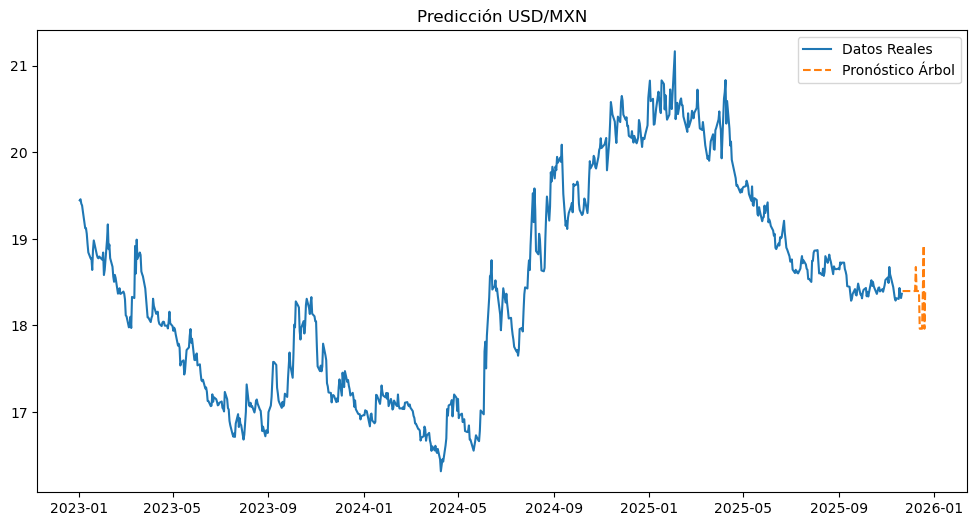

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Configuración
dias_a_predecir = 30  # Ventana de predicción (Forecast)

def obtener_datos(ticker):
    # Descargar datos históricos (ej. últimos 2 años para tener contexto)
    df = yf.download(ticker, start="2023-01-01", end="2025-11-24")
    df = df[['Close']] # Nos interesa el precio de cierre
    # Crear la variable objetivo desplazada 'n' días hacia el futuro
    df['Prediction'] = df[['Close']].shift(-dias_a_predecir)
    return df

# ==========================================
# CASO 1: USD/MXN con Árbol de Regresión
# ==========================================
print("--- Procesando USD/MXN ---")
df_mxn = obtener_datos("MXN=X") # Ticker de Yahoo para Peso Mexicano

# Preprocesamiento
X_mxn = np.array(df_mxn.drop(['Prediction'], axis=1))[:-dias_a_predecir]
y_mxn = np.array(df_mxn['Prediction'])[:-dias_a_predecir]

# Split 80/20
x_train, x_test, y_train, y_test = train_test_split(X_mxn, y_mxn, test_size=0.2, shuffle=False)

# Modelo: Árbol
tree = DecisionTreeRegressor(max_depth=5) # Limitamos profundidad para evitar overfitting
tree.fit(x_train, y_train)

# Evaluación
score_tree = tree.score(x_test, y_test)
print(f"Precisión del Árbol (R2): {score_tree:.4f}")

# Proyección a futuro (Los días que no tienen etiqueta 'Prediction')
X_futuro_mxn = np.array(df_mxn.drop(['Prediction'], axis=1))[-dias_a_predecir:]
pronostico_mxn = tree.predict(X_futuro_mxn)

# ==========================================
# CASO 2: Bitcoin con SVR (RBF)
# ==========================================
print("\n--- Procesando BITCOIN ---")
df_btc = obtener_datos("BTC-USD")

# Nota: SVR REQUIERE escalado de datos para funcionar bien
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_btc = np.array(df_btc.drop(['Prediction'], axis=1))[:-dias_a_predecir]
y_btc = np.array(df_btc['Prediction'])[:-dias_a_predecir].reshape(-1, 1)

# Escalar
X_btc = scaler_X.fit_transform(X_btc)
y_btc = scaler_y.fit_transform(y_btc)

x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(X_btc, y_btc, test_size=0.2, shuffle=False)

# Modelo: SVR con RBF
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(x_train_b, y_train_b.ravel())

# Evaluación
score_svr = svr.score(x_test_b, y_test_b)
print(f"Precisión del SVR (R2): {score_svr:.4f}")

# Proyección a futuro
X_futuro_btc = np.array(df_btc.drop(['Prediction'], axis=1))[-dias_a_predecir:]
X_futuro_btc = scaler_X.transform(X_futuro_btc) # Usar el mismo scaler
pronostico_btc_scaled = svr.predict(X_futuro_btc)
# Invertir la escala para ver el precio real
pronostico_btc = scaler_y.inverse_transform(pronostico_btc_scaled.reshape(-1, 1))

# ==========================================
# Visualización de Resultados
# ==========================================
print("\n--- Pronóstico para los próximos 30 días (Muestra) ---")
print(f"USD/MXN (Día 30): {pronostico_mxn[-1]:.2f}")
print(f"Bitcoin (Día 30): {pronostico_btc[-1][0]:.2f}")

# Graficar USD/MXN
plt.figure(figsize=(12,6))
plt.plot(df_mxn.index, df_mxn['Close'], label='Datos Reales')
# Crear fechas futuras para graficar
fechas_futuras = pd.date_range(df_mxn.index[-1], periods=dias_a_predecir+1)[1:]
plt.plot(fechas_futuras, pronostico_mxn, label='Pronóstico Árbol', linestyle='--')
plt.title("Predicción USD/MXN")
plt.legend()
plt.show()